In [1]:
from cellpose import models
from cellpose import core
from cellpose import dynamics
import os
from u_net_clean import get_images_masks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from dynamics_model import get_data
from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/unetenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reg_data(imgs, cellpose_model):
    #get the cellprobs as those will be the Xs
    #get the cellpose masks as those will be the Ys

    

    masks, flows, styles = model.eval(imgs,channels=[[0,0]],cellprob_threshold=0.0)

    print('len masks',len(masks))

    plt.imshow(masks[0])
    plt.show()

    #print(flows)
    #print('\n')
    #print(flows[0])

    cellprobs = []
    for i in range(len(flows)):
        cellprobs.append(flows[i][2])

    binary_masks = []
    for i in range(len(masks)):
        binary_masks.append(np.where(masks[i]>0,1,0))

    plt.subplot(2,2,1)
    plt.imshow(cellprobs[0])

    plt.subplot(2,2,2)
    plt.imshow(binary_masks[0])

    plt.subplot(2,2,3)
    plt.imshow(cellprobs[1])

    plt.subplot(2,2,4)
    plt.imshow(binary_masks[1])

    plt.show()


    return cellprobs, binary_masks


In [3]:
images_path = os.getcwd() + '/812_plate/'
masks_path = os.getcwd() + '/812_plate_masks/'

print('Getting images')
images, masks = get_images_masks(images_path, masks_path,num_imgs=1)
imgs, mks = get_data(images,masks,flows=True,split=False)
print('Got images\n')

#X_train, X_test, y_train, y_test = train_test_split(imgs, mks, test_size=0.2, random_state=42)

Getting images
mks 1: [0.         0.02058922 0.03495283 ... 0.97308654 0.9879761  1.        ]
(1, 1080, 1080)
Got images



In [4]:
print('Making cellpose model')
model = models.CellposeModel(model_type='nuclei',gpu=core.use_gpu())
print('Made cellpose model\n')

Making cellpose model
Made cellpose model



Getting reg data
len masks 10


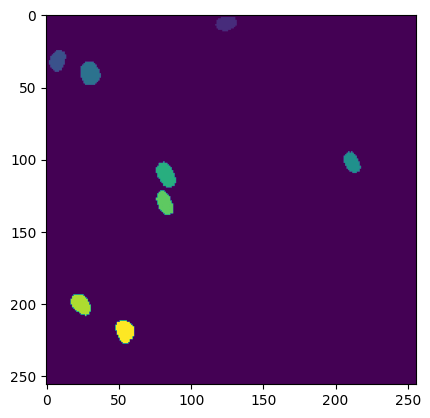

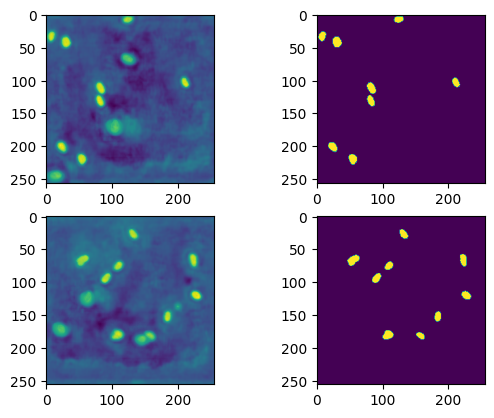

Got data



In [5]:
print('Getting reg data')
X, y = reg_data(imgs,model)
print('Got data\n')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train_np = np.array([np.array(X_train[i]).flatten() for i in range(len(X_train))])
X_test_np = np.array([np.array(X_test[i]).flatten() for i in range(len(X_test))])
y_train_np = np.array([np.array(y_train[i]).flatten() for i in range(len(y_train))])
y_test_np = np.array([np.array(y_test[i]).flatten() for i in range(len(y_test))])

In [7]:
print('Training model')
reg = LinearRegression().fit(X_train_np[:2], y_train_np[:2])
print('Done training model')

Training model


: 

: 

In [ ]:
pred1 = reg.predict(y_test_np[0])
pred2 = reg.predict(y_test_np[1])